In [1]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')
#!pip3 install torch torchvision torchaudio

In [15]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2.bin"

In [95]:
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection
from torch import LongTensor
from sklearn.metrics import f1_score, confusion_matrix, classification_report

---

In [3]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_cleaned.csv')

In [4]:
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 3


0

In [5]:
idx = 0
print(sentences[idx])
print(aspect_tags[idx])
print(polarity_tags[idx])

['I', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord', 'with', 'me', 'because', 'of', 'the', 'good', 'battery', 'life']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


---

In [82]:
def get_new_aspect_cluster(left, right, aspect_term, polarity, sentence):

    if len(polarity) == 0:
        polarity = 0
    else:
        polarity = int(sum(polarity)/len(polarity))
   
    left.extend(aspect_term)
    left.extend(right)
    return {
        "local_context":left,
        "global_context":sentence,
        "aspect_term":aspect_term,
        "polarity":polarity,
    }

def chop(sentence, aspect_tag, polarity_tag):
    ret_aspect_clusters = []
#     ret_aspect_clusters = {
#         "context":list(),
#         "aspect_term":list(),
#         "polarity":list(),
#     }
    left = []
    right = []
    aspect_term = []
    polarity = []
    doing_left = True
    doing_right = False
    doing_aspect = False
    for i in range(len(sentence)):
        # check if the current token is an aspect term
        if aspect_tag[i] == 0:
            if doing_left:
                doing_aspect = True
                doing_left = False
            elif doing_right:
                doing_right = False
                doing_aspect = True
                # Now, need to save the previous aspect term cluster
                ret_aspect_clusters.append(get_new_aspect_cluster(
                    left, right, aspect_term, polarity, sentence))
                left = right
                right = []
                aspect_term = []
                polarity = []
            aspect_term.append(sentence[i])
            polarity.append(polarity_tag[i])
        else:
            if doing_left:
                left.append(sentence[i])
            elif doing_right:
                right.append(sentence[i])
            else:
                doing_aspect = False
                doing_right = True
                right.append(sentence[i])
                
    ret_aspect_clusters.append(get_new_aspect_cluster(
        left, right, aspect_term, polarity, sentence))
    
    return ret_aspect_clusters

In [83]:
all_aspect_clusters = []
for i in range(len(sentences)):
    all_aspect_clusters.extend(chop(sentences[i], aspect_tags[i], polarity_tags[i]))

In [85]:
all_aspect_clusters[0]

{'local_context': ['I',
  'charge',
  'it',
  'at',
  'night',
  'and',
  'skip',
  'taking',
  'the',
  'cord',
  'with',
  'me',
  'because',
  'of',
  'the',
  'good'],
 'global_context': ['I',
  'charge',
  'it',
  'at',
  'night',
  'and',
  'skip',
  'taking',
  'the',
  'cord',
  'with',
  'me',
  'because',
  'of',
  'the',
  'good',
  'battery',
  'life'],
 'aspect_term': ['cord'],
 'polarity': 0}

In [91]:
# generate word_index list
def build_vocab(lst):
    result = []
    for i in lst:
        result.extend(i[0]+i[1])
    word_idx = {}
    for idx, word in enumerate(sorted(set(result))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(all_aspect_clusters,  word_idx, sent_len=83):

    train_X_local = np.zeros((len(all_aspect_clusters), sent_len), np.int16)
    train_X_global = np.zeros((len(all_aspect_clusters), sent_len), np.int16)

    train_y = np.zeros(len(all_aspect_clusters), np.int16)

    # iterate the asoect
    for sx, sent in enumerate(all_aspect_clusters):
        train_y[sx] = sent['polarity']
        global_sentence = sent['global_context']
        local_sentence = sent['local_context']
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(global_sentence):
                train_X_global[sx, wx] = word_idx[word]

            for wx, word in enumerate(local_sentence):
                train_X_local[sx, wx] = word_idx[word]

        except KeyError:
            continue

    return train_X_local, train_X_global, train_y


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, label, num_label):
    pred = pred.view(-1,num_label)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        true_tags = torch.cat(true_tags, 0)
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1, 2], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())
    return acc, f1, cm


class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3, alpha = 0.6):
        super(Model, self).__init__()
  
        self.embed = nn.Embedding.from_pretrained(torch.tensor(gen_emb, dtype=torch.float))
        self.lstm_l = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=False, batch_first=True)
        self.lstm_r = nn.LSTM(gen_emb.shape[1],hidden_size=150, num_layers=1, bidirectional=False, batch_first=True)

        self.dense = nn.Linear(150*2, num_classes)

        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense_1 = torch.nn.Linear(gen_emb.shape[1], num_classes)

        self.alpha = alpha
        self.dropout = nn.Dropout(0.3)


    def forward(self, x_train_local, x_train_global):

        #left_seq_lengths = torch.tensor([0]*len(x_train_left))
        #right_seq_lengths = torch.tensor([0]*len(x_train_right))

        '''
        # increate length to set to min one to avoid 0 length for pack padded sequence
        for i, seq in enumerate(x_train_left):
            if len(seq) == 0:
                left_seq_lengths[i] = 1
            else:
                non_zero_seq = seq[seq.nonzero().squeeze().detach()]
                if non_zero_seq.dim() == 0:
                    left_seq_lengths[i] = 1
                else:
                    left_seq_lengths[i] = len(non_zero_seq)

        for i, seq in enumerate(x_train_right):
            if len(seq) == 0:
                right_seq_lengths[i] = 1
            else:
                non_zero_seq = seq[seq.nonzero().squeeze().detach()]
                if non_zero_seq.dim() == 0:
                    right_seq_lengths[i] = 1
                else:
                    right_seq_lengths[i] = len(non_zero_seq)
        

        x_l = self.embed(x_train_left)
        x_r = self.embed(x_train_right)

        x_emb_p_l = torch.nn.utils.rnn.pack_padded_sequence(x_l, left_seq_lengths, batch_first=True, enforce_sorted=False)

        _, (ht, _) = self.lstm_l(x_emb_p_l)

        x_emb_p_r = torch.nn.utils.rnn.pack_padded_sequence(x_r, right_seq_lengths, batch_first=True, enforce_sorted=False)

        _, (ht_r, _) = self.lstm_l(x_emb_p_r)

        h_n = torch.cat((ht[0], ht_r[0]), dim=-1)
        #output1 = self.dense(h_n)

        '''
        x_local = self.embed(x_train_local)
        _, (h_n, _) = self.lstm(x_local.float())

        h_n = torch.cat([h_n[-2,:,:], h_n[-1,:,:]], dim=1)

        x_global = self.embed(x_train_global)
        _, (h_n_g,_) = self.lstm(x_global.float())

        h_n_g = torch.cat([h_n_g[-2,:,:], h_n_g[-1,:,:]], dim=1)

        avg_pool = torch.div(torch.add(h_n * (1 - self.alpha), h_n_g * self.alpha), 2)
        out = self.dropout(avg_pool)

        out = self.dense(out)


        return out

In [87]:
word_indx = build_vocab(left_right)
    
fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)

In [89]:
local_context, global_context, y = create_train_data_restaurant(all_aspect_clusters ,word_indx, sent_len=83)

X_l_train, X_l_valid, X_g_train, X_g_valid,  y_train, y_valid = train_test_split(local_context, global_context, y, test_size=VALID_SIZE)


In [98]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.7), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4586
valid samples:1147


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 0
	train_loss:1.069 valid_loss:1.051
	train_acc:52.68% valid_acc:52.40%
	train_f1:0.369 valid_f1:0.360
	train_confusion_matrix:
[[   3  834    3]
 [  25 2356    3]
 [   8 1247    1]]
	valid_confusion_matrix:
[[  0 197   0]
 [  0 601   0]
 [  0 349   0]]


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]



epoch 1
	train_loss:1.019 valid_loss:1.009
	train_acc:53.33% valid_acc:52.40%
	train_f1:0.371 valid_f1:0.360
	train_confusion_matrix:
[[   0  824    0]
 [   0 2389    0]
 [   0 1267    0]]
	valid_confusion_matrix:
[[  0 197   0]
 [  0 601   0]
 [  0 349   0]]


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]



epoch 2
	train_loss:0.982 valid_loss:0.979
	train_acc:53.39% valid_acc:52.40%
	train_f1:0.372 valid_f1:0.360
	train_confusion_matrix:
[[   0  830    0]
 [   0 2392    0]
 [   0 1258    0]]
	valid_confusion_matrix:
[[  0 197   0]
 [  0 601   0]
 [  0 349   0]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 3
	train_loss:0.932 valid_loss:0.901
	train_acc:53.57% valid_acc:55.62%
	train_f1:0.380 valid_f1:0.442
	train_confusion_matrix:
[[   0  820   10]
 [   0 2380    8]
 [   0 1242   20]]
	valid_confusion_matrix:
[[  0 178  19]
 [  0 586  15]
 [  0 297  52]]


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]



epoch 4
	train_loss:0.866 valid_loss:0.845
	train_acc:59.69% valid_acc:61.81%
	train_f1:0.508 valid_f1:0.551
	train_confusion_matrix:
[[   0  631  204]
 [   0 2277  120]
 [   0  851  397]]
	valid_confusion_matrix:
[[  0 111  86]
 [  0 534  67]
 [  0 174 175]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 5
	train_loss:0.831 valid_loss:0.821
	train_acc:64.29% valid_acc:66.09%
	train_f1:0.576 valid_f1:0.601
	train_confusion_matrix:
[[   0  415  418]
 [   0 2079  307]
 [   0  460  801]]
	valid_confusion_matrix:
[[  0  81 116]
 [  0 508  93]
 [  0  99 250]]


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]



epoch 6
	train_loss:0.807 valid_loss:0.800
	train_acc:65.42% valid_acc:67.22%
	train_f1:0.587 valid_f1:0.612
	train_confusion_matrix:
[[   0  421  416]
 [   0 2087  305]
 [   0  407  844]]
	valid_confusion_matrix:
[[  0  79 118]
 [  0 514  87]
 [  0  92 257]]


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]



epoch 7
	train_loss:0.788 valid_loss:0.778
	train_acc:66.45% valid_acc:67.83%
	train_f1:0.601 valid_f1:0.615
	train_confusion_matrix:
[[   0  339  500]
 [   0 2020  363]
 [   0  301  957]]
	valid_confusion_matrix:
[[  0  95 102]
 [  0 526  75]
 [  0  97 252]]


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]



epoch 8
	train_loss:0.770 valid_loss:0.758
	train_acc:66.94% valid_acc:69.14%
	train_f1:0.605 valid_f1:0.631
	train_confusion_matrix:
[[   0  351  484]
 [   0 2040  346]
 [   0  300  959]]
	valid_confusion_matrix:
[[  0  73 124]
 [  0 514  87]
 [  0  70 279]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 9
	train_loss:0.752 valid_loss:0.755
	train_acc:67.83% valid_acc:68.79%
	train_f1:0.613 valid_f1:0.629
	train_confusion_matrix:
[[   0  343  489]
 [   0 2050  338]
 [   0  271  989]]
	valid_confusion_matrix:
[[  0  66 131]
 [  0 502  99]
 [  0  62 287]]


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]



epoch 10
	train_loss:0.740 valid_loss:0.743
	train_acc:68.39% valid_acc:68.79%
	train_f1:0.619 valid_f1:0.624
	train_confusion_matrix:
[[   1  343  485]
 [   0 2056  338]
 [   0  250 1007]]
	valid_confusion_matrix:
[[  0  95 102]
 [  0 533  68]
 [  0  93 256]]


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]



epoch 11
	train_loss:0.733 valid_loss:0.729
	train_acc:68.55% valid_acc:69.66%
	train_f1:0.620 valid_f1:0.635
	train_confusion_matrix:
[[   0  340  496]
 [   0 2046  332]
 [   0  241 1025]]
	valid_confusion_matrix:
[[  0  76 121]
 [  0 516  85]
 [  0  66 283]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 12
	train_loss:0.723 valid_loss:0.720
	train_acc:68.95% valid_acc:69.92%
	train_f1:0.623 valid_f1:0.637
	train_confusion_matrix:
[[   2  378  456]
 [   3 2074  307]
 [   0  247 1013]]
	valid_confusion_matrix:
[[  2  97  98]
 [  0 536  65]
 [  2  83 264]]


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]



epoch 13
	train_loss:0.707 valid_loss:0.708
	train_acc:69.87% valid_acc:70.71%
	train_f1:0.633 valid_f1:0.647
	train_confusion_matrix:
[[   5  368  459]
 [   6 2095  285]
 [   0  232 1030]]
	valid_confusion_matrix:
[[  3  87 107]
 [  2 528  71]
 [  2  67 280]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 14
	train_loss:0.695 valid_loss:0.709
	train_acc:70.54% valid_acc:70.79%
	train_f1:0.643 valid_f1:0.657
	train_confusion_matrix:
[[  16  364  450]
 [  11 2104  278]
 [   8  209 1040]]
	valid_confusion_matrix:
[[ 14 107  76]
 [  5 555  41]
 [  5 101 243]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 15
	train_loss:0.692 valid_loss:0.718
	train_acc:70.51% valid_acc:70.10%
	train_f1:0.647 valid_f1:0.655
	train_confusion_matrix:
[[  32  383  420]
 [  32 2112  243]
 [   9  234 1015]]
	valid_confusion_matrix:
[[ 11  71 115]
 [  4 503  94]
 [  6  53 290]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 16
	train_loss:0.684 valid_loss:0.687
	train_acc:71.54% valid_acc:71.32%
	train_f1:0.668 valid_f1:0.674
	train_confusion_matrix:
[[  73  345  416]
 [  31 2090  261]
 [  18  204 1042]]
	valid_confusion_matrix:
[[ 23  95  79]
 [ 16 537  48]
 [  6  85 258]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 17
	train_loss:0.674 valid_loss:0.681
	train_acc:71.65% valid_acc:71.40%
	train_f1:0.672 valid_f1:0.678
	train_confusion_matrix:
[[  80  353  398]
 [  43 2112  232]
 [  31  213 1018]]
	valid_confusion_matrix:
[[ 25  93  79]
 [ 18 536  47]
 [ 14  77 258]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 18
	train_loss:0.656 valid_loss:0.689
	train_acc:72.66% valid_acc:72.19%
	train_f1:0.692 valid_f1:0.695
	train_confusion_matrix:
[[ 127  333  368]
 [  55 2123  217]
 [  55  197 1005]]
	valid_confusion_matrix:
[[ 36  79  82]
 [ 26 522  53]
 [ 16  63 270]]


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


epoch 19
	train_loss:0.646 valid_loss:0.680
	train_acc:73.21% valid_acc:72.80%
	train_f1:0.699 valid_f1:0.694
	train_confusion_matrix:
[[ 138  314  379]
 [  53 2106  228]
 [  48  178 1036]]
	valid_confusion_matrix:
[[ 31  91  75]
 [ 15 542  44]
 [ 12  75 262]]


(0.4, 0.9)

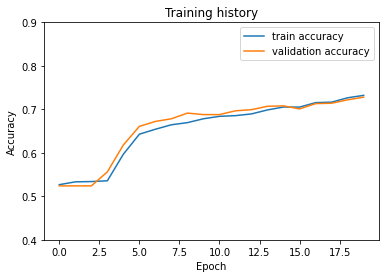

In [99]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [100]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

              precision    recall  f1-score   support

     Neutral       0.49      0.15      0.23       197
    Positive       0.76      0.90      0.83       601
    Negative       0.69      0.75      0.72       349

    accuracy                           0.72      1147
   macro avg       0.65      0.60      0.59      1147
weighted avg       0.69      0.72      0.69      1147

